## Multi-agent Test
- Supervisor Agent
    - general_conversation:
    - rag: load Clark vectorstore with metadata info (`ncae-c` course materials)
    - web_researcher: search for information that not in the vectorstore
    - CLI-Chatbot (with memory support)

Since 2025

v. 0.2.2

## Code

In [3]:
import glob
import os
from typing import Annotated, Dict, List, Literal, Sequence

from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.tools import tool
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command
from pydantic import BaseModel
from typing_extensions import TypedDict


# Load environment variables
load_dotenv()
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']

# Initialize LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.8)

# Define available agents
members = ["general_conversation", "web_researcher", "rag"]
options = members + ["FINISH"]

# Supervisor system prompt 
system_prompt = """
You are a supervisor managing a conversation between a user and AI agents: a general conversation agent, a RAG agent, and a web researcher agent. 

- The general conversation agent handles small talk and guides users toward cybersecurity topics.
- The RAG agent searches through the CLARK library, a compilation of high-value cybersecurity curriculum.
- The web researcher agent searches the internet for additional information.

Your task is to route the conversation to the appropriate agent or to finish the conversation based on the following rules:

1. For a new user query:
   - If it's small talk, a greeting, or a casual conversation, route to 'general_conversation'.
   - If it's a cybersecurity question, route to 'rag' to search the CLARK library.

2. After the 'general_conversation' agent responds:
   - If the conversation should continue as general discussion, route to 'FINISH'.
   - If the user asks a cybersecurity question, route to 'rag'.

3. After the 'rag' agent responds:
   - If the response adequately answers the user's query using CLARK resources, route to 'FINISH'.
   - If the response indicates that no relevant information was found in the CLARK library or does not adequately answer the query, route to 'web_researcher' agent.

4. After the 'web_researcher' agent responds, route to 'FINISH'.

To make this decision, consider:
- Is the user's message small talk or a casual greeting?
- Is the user asking about a specific cybersecurity topic?
- Did the previous agent provide a satisfactory response?

Respond with a JSON object containing the key 'next' and the value being one of: 'general_conversation', 'rag', 'web_researcher', or 'FINISH'. For example: {"next": "general_conversation"}
"""

class Router(TypedDict):
    next: Literal["general_conversation", "rag", "web_researcher", "FINISH"]

def supervisor_node(state: MessagesState) -> Command[Literal["general_conversation", "rag", "web_researcher", "__end__"]]:
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)

# Define AgentState
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

# Updated create_agent function to accept a system_prompt
def create_agent(llm, tools, system_prompt: str = ""):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
        # Include system_prompt if provided
        messages = (
            [{"role": "system", "content": system_prompt}] + state["messages"]
            if system_prompt
            else state["messages"]
        )
        return {"messages": [llm_with_tools.invoke(messages)]}
    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)
    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)
    graph_builder.add_conditional_edges("agent", tools_condition)
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()

# General Conversation Agent
general_conversation_system_prompt = """
You are a friendly cybersecurity teaching assistant named CyberGuide. Your primary goal is to help students learn about cybersecurity concepts.

For general conversation or small talk:
1. Respond in a friendly, conversational manner
2. Keep responses brief and engaging
3. When appropriate, gently guide the conversation toward cybersecurity topics with suggestions like:
   "Would you like to learn about network security basics?"
   "Have you considered exploring topics like encryption or penetration testing?"
   "I can help you understand cybersecurity concepts from the CLARK library. What topic interests you?"

Remember that you're designed to be both approachable for beginners and helpful for more advanced cybersecurity students.
"""

# No tools needed for general conversation
general_conversation_agent = create_agent(llm, [], general_conversation_system_prompt)

def general_conversation_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = general_conversation_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="general_conversation")]},
        goto="supervisor",
    )

# Web search agent
web_search_tool = TavilySearchResults(max_results=2)
web_researcher_system_prompt = """
You are an AI assistant tasked with searching the internet for information to answer the user's query about cybersecurity. 
Use the web_search_tool to find relevant information. 
In your response, include the information found and cite the sources (e.g., URLs or references provided by the tool).
"""
websearch_agent = create_agent(llm, [web_search_tool], web_researcher_system_prompt)

def web_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = websearch_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="web_researcher")]},
        goto="supervisor",
    )

# Function to recursively find all PDFs
def get_all_pdfs(directory: str) -> List[str]:
    return glob.glob(f"{directory}/**/*.pdf", recursive=True)

# CLARK library vector store function
def load_clark_vectorstore(db_path: str, base_dir: str):
    if os.path.exists(db_path):
        embeddings = OpenAIEmbeddings()
        vectorstore = FAISS.load_local(
            db_path, embeddings, allow_dangerous_deserialization=True
        )
        print(f"CLARK Vector DB loaded at {db_path}")
    else:
        pdf_files = get_all_pdfs(base_dir)
        if not pdf_files:
            print(f"Warning: No PDF files found in {base_dir} or its subdirectories")
            embeddings = OpenAIEmbeddings()
            vectorstore = FAISS.from_documents([Document(page_content="Empty document")], embedding=embeddings)
            vectorstore.save_local(db_path)
            return vectorstore
        
        print(f"Found {len(pdf_files)} PDF files in {base_dir}")
        documents = []
        
        for pdf_path in pdf_files:
            try:
                parts = pdf_path.split(os.sep)
                if len(parts) >= 4:
                    collection_name = parts[-4]
                    course_name = parts[-3]
                    module_name = parts[-2]
                    file_name = parts[-1]
                else:
                    collection_name = "unknown_collection"
                    course_name = "unknown_course"
                    module_name = "unknown_module"
                    file_name = os.path.basename(pdf_path)

                loader = PyPDFLoader(pdf_path)
                pages = loader.load()
                
                for page in pages:
                    page.metadata.update({
                        "collection_name": collection_name,
                        "course_name": course_name,
                        "module_name": module_name,
                        "file_path": pdf_path,
                        "file_name": file_name
                    })
                documents.extend(pages)
                print(f"Loaded {pdf_path} with metadata")
            except Exception as e:
                print(f"Error loading {pdf_path}: {e}")

        text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
        docs = text_splitter.split_documents(documents)
        embeddings = OpenAIEmbeddings()
        vectorstore = FAISS.from_documents(docs, embedding=embeddings)
        vectorstore.save_local(db_path)
        print(f"CLARK Vector DB created at {db_path} with {vectorstore.index.ntotal} documents")
    
    return vectorstore

clark_db_path = "db/clark_db/clark_library_db"
clark_base_dir = "rag/clark_doc"
clark_vectorstore = load_clark_vectorstore(clark_db_path, clark_base_dir)

class RagToolSchema(BaseModel):
    question: str

@tool(args_schema=RagToolSchema)
def clark_retriever_tool(question: str) -> str:
    """
    Retrieve cybersecurity educational resources from the CLARK library, the largest compilation of high-value, high-impact cybersecurity curriculum. 
    This tool provides access to modular content including lecture notes, labs, slides, quiz and more for teaching and learning cybersecurity materials.
    """
    print("INSIDE CLARK RETRIEVER NODE")
    retriever = clark_vectorstore.as_retriever(search_kwargs={"k": 3})
    retriever_result = retriever.invoke(question)

    if not retriever_result:
        return "No relevant cybersecurity information found in the CLARK library."

    formatted_response = []
    for doc in retriever_result:
        metadata = doc.metadata
        entry = (
            f"**Content:**\n{doc.page_content}\n\n"
            f"**Metadata:**\n"
            f"- Collection: {metadata['collection_name']}\n"
            f"- Course: {metadata['course_name']}\n"
            f"- Module: {metadata['module_name']}\n"
            f"- File: {metadata['file_name']}\n"
            f"- Path: {metadata['file_path']}"
        )
        formatted_response.append(entry)
    
    return "\n\n---\n\n".join(formatted_response)

# RAG agent with system prompt
rag_system_prompt = """
You are CyberGuide, an AI assistant tasked with retrieving and presenting cybersecurity educational resources from the CLARK library. 

When you receive a query, use the clark_retriever_tool to search the library. 
The tool will return relevant content along with metadata such as collection name, course name, and module name. 

In your response:
1. Include the retrieved content in a clear, organized way
2. Clearly mention the source metadata (collection name, course name, module name) 
3. Explain cybersecurity concepts in an educational manner appropriate for students
4. If the content is complex, provide additional explanations to make it more accessible

Always maintain a helpful, encouraging tone to support students in their cybersecurity learning journey.
"""
rag_agent = create_agent(llm, [clark_retriever_tool], rag_system_prompt)

def rag_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = rag_agent.invoke(state)
    return Command(
        update={"messages": [HumanMessage(content=result["messages"][-1].content, name="rag")]},
        goto="supervisor",
    )

# Build the graph
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("general_conversation", general_conversation_node)
builder.add_node("web_researcher", web_research_node)
builder.add_node("rag", rag_node)

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

CLARK Vector DB loaded at db/clark_db/clark_library_db


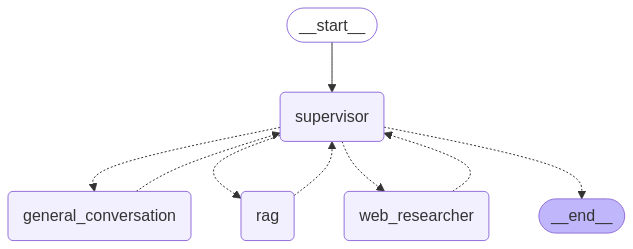

In [4]:
# Optional: Visualize the graph
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")


## Test Case

### Chatbot

In [5]:
def chat_with_graph(graph, thread_id) -> Dict[str, str]:
    """
    Run an interactive chatbot session with the LangGraph workflow, handling multiple questions.

    Args:
        graph: The compiled LangGraph instance.

    Returns:
        Dict containing the final conversation state (last query, final answer, and all steps).
    """
    # Initialize persistent state with a thread_id for the checkpointer
    config = {"configurable": {"thread_id": thread_id}}  # Unique thread ID for this session
    state = {"messages": []}
    
    # Result dictionary to store conversation summary
    result_info = {
        "last_query": "",
        "final_answer": "",
        "steps": []
    }

    # Print welcome message
    print(f"{'='*50}\nWelcome to the Cybersecurity Chatbot!\nType your question or 'exit' to quit.\n{'='*50}")

    while True:
        # Get user input
        query = input("You: ").strip()
        
        # Check for exit condition
        if query.lower() in ["exit", "quit"]:
            print(f"{'='*50}\nChat session ended.\n{'='*50}")
            break

        # Update state with new user message
        state["messages"].append(HumanMessage(content=query))
        result_info["last_query"] = query

        # Print query header
        print(f"{'='*50}\nProcessing Query: '{query}'\n{'='*50}")

        # Execute the graph with the current state and config
        result = graph.invoke(state, config=config)  # Pass config with thread_id
        messages = result["messages"]

        # Process each new message since the last turn
        for msg in messages[len(state["messages"]) - 1:]:
            sender = msg.name if hasattr(msg, "name") and msg.name else ("User" if isinstance(msg, HumanMessage) else "Unknown")
            formatted_msg = f"{sender}: {msg.content}"

            # Determine step type
            if sender == "supervisor":
                step_info = f"Supervisor: Routing decision based on prior message"
            elif hasattr(msg, "tool_calls") and msg.tool_calls:
                tool_name = msg.tool_calls[0]["name"] if msg.tool_calls else "Unknown Tool"
                step_info = f"Agent: {sender}\nTool: {tool_name}\nOutput: {msg.content}"
            elif sender not in ["User", "supervisor"]:
                step_info = f"Agent: {sender}\nOutput: {msg.content}"
            else:
                step_info = formatted_msg

            # Log step
            print(step_info)
            print("-" * 50)
            result_info["steps"].append(step_info)

        # Extract final answer for this turn (last agent message)
        final_answer = next(
            (msg.content for msg in reversed(messages) if hasattr(msg, "name") and msg.name and msg.name not in ["supervisor", None]),
            "No answer provided."
        )
        result_info["final_answer"] = final_answer

        # Print final answer for this turn
        print(f"{'='*50}\nFinal Answer to You:\n{'-'*20}\n{final_answer}\n{'='*50}")

        # Update state for the next iteration
        state = result

    return result_info

# Run the chat
result = chat_with_graph(graph, 'test_12345')

Welcome to the Cybersecurity Chatbot!
Type your question or 'exit' to quit.
Processing Query: 'my name is Tim'
Next Worker: general_conversation
Next Worker: FINISH
User: my name is Tim
--------------------------------------------------
Agent: general_conversation
Output: Hi Tim! It’s great to meet you! How’s your day going? If you're interested, we could chat about some cybersecurity topics!
--------------------------------------------------
Final Answer to You:
--------------------
Hi Tim! It’s great to meet you! How’s your day going? If you're interested, we could chat about some cybersecurity topics!
Processing Query: 'what is asymtric encryption'
Next Worker: rag
INSIDE CLARK RETRIEVER NODE
Next Worker: FINISH
User: what is asymtric encryption
--------------------------------------------------
Agent: rag
Output: Asymmetric encryption, also known as public key encryption, is a crucial concept in cybersecurity. Here's a breakdown of what it entails:

### What is Asymmetric Encryptio